<div style="width: 100%; clear: both; font-family: Verdana;">
<div style="float: left; width: 50%;font-family: Verdana;">
<img src="https://github.com/Eligoze/att-rci-internal/blob/qa/RCI_DataAnalysis/eda/doc/att-logo1.png" align="left">
</div>
<div style="float: right; width: 200%;">
<p style="margin: 0; padding-top: 20px; text-align:right;color:rgb(193, 38, 184)"><strong>Axity - AT&T.
    Ciclo de vida de elementos de inventario</strong></p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Exploratory Data Analysis
## Ciclo de vida de elementos de inventario.
### Axity - AT&T.

## Descripción
Analizaremos los datos de las fuentes de inventarios de AT&T con un tratamiento estadístico descriptivo para hacer el tracking del ciclo de vida de los elementos de red. Se creará un EDA enfocado a la salida de almacén. Serán documentados los catálogos propuestos junto a su respectivo tratamiento de datos. La fuente que corresponde a este análisis es:

* **GESTOR DIGIDATA**

Primero cargamos las librerías necesarias.

#### Conectando al Datalake

In [1]:
import os
os.environ['JAVA_HOME'] = '/usr/java/jdk1.8.0_162'
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import HiveContext
from pyspark.sql.types import *


In [2]:
conf = SparkConf().setAppName('tx_netcm_cisco_epn')  \
        .setMaster('yarn').set("spark.yarn.queue","root.eda").set("spark.executor.extrajavaoptions","-Xmx1024m").set("spark.sql.autoBroadcastJoinThreshold","50485760").set("spark.sql.join.preferSortMergeJoin", "true").set("spark.sql.codegen.wholeStage","true").set("spark.sql.inMemoryColumnarStorage.compressed","true").set("spark.sql.codegen","true").set("spark.kryoserializer.buffer.mb","128").set("spark.yarn.executor.memoryOverhead","20g")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sqlContext = HiveContext(sc)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re

from pyspark.sql.functions import udf ,col
from pyspark.sql.types import *

%matplotlib inline

from bokeh.io import show, output_notebook, output_file 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20_11, Category20c_20, Category10_5,Category10_6, Category20_20, Plasma256
output_notebook()

Loading BokehJS ...

# NETCM

## 1.1 NETCM Cisco EPN

### Recolección de los datos: 

Para analizar el gestor NETCM en conjunto, se realiza una unión de las fuentes huawei_cobs y huawei_bts para trabajar una parte del universo de NETCM.

La tablas que se utilizan como fuentes son ```tx_netcm_huawei_cobs```, ```tx_netcm_huawei_bts```, ```tx_netcm_cisco_epn``` y ```tx_netcm_ericsson```.

El campo utilizado para la unión de las tablas de huawei es: ```serial_number```.

Los datos con los que se trabajan a lo largo del EDA corresponden a la partición de **201911** para todas las tablas.

*IMPORTANTE*: Si se requieren ver datos de otro periodo, se debe cambiar los filtros ```year = <año-a-ejecutar>```, ```month = <mes-a-ejecutar>```, ```day = <día-a-ejecutar>``` de las tablas en la siguiente celda:

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se crea el dataframe de spark
    </p>
</div>

In [4]:
df_load =spark.sql("select * from tx_netcm_cisco_epn where year = 2019 and month=11").cache()#.toPandas() 

In [5]:
df_load.columns

['omip',
 'productfamily',
 'creationtime',
 'nodename',
 'softwaretype',
 'managementstatus',
 'ipaddress',
 'devicename',
 'serial_number',
 'sheet_name',
 'technology',
 'manufacturerpartnr',
 'adminstatus',
 'location',
 'reachability',
 'devicetypeparameter',
 'filedate',
 'filename',
 'hash_id',
 'sourceid',
 'registry_state',
 'datasetname',
 'timestamp',
 'transaction_status',
 'year',
 'month',
 'day']

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Creamos una funcion para el tratamiento de datos en spark el cual contiene la reglas definidas para la columna serie:
    </p>
</div>

In [6]:
def validate_rule(string):
    
    search_list=[" ",'!','%','$',"<",">","^",'¡',"+","N/A",'¿','~','#','Ñ',"Ã","Åƒ","Ã‹","Ã³",'Ë','*','?',"ILEGIBLE", "VICIBLE","VISIBLE","INCOMPLETO"]
    test = u'%s' % (string)
    str_temp = test.decode('utf-8')
    if str_temp.upper() == "BORRADO":
      return 0
    elif len(str_temp) < 6:
      return 0
    elif any(ext.decode("utf-8") in str_temp.upper()for ext in search_list):
      return 0
    else:
      return 1

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se crea un udf en spark sobre la funcion ya creada 
    </p>
</div>

In [7]:
validate_rule_udf = udf(validate_rule, IntegerType())

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se le agrega una nueva columna al dataframe de spark; la nueva columna es la validacion de la columna serie con respecto al udf que creamos.
    </p>
</div>

In [8]:
df_serie = df_load.withColumn("serie_cleaned",validate_rule_udf(col("serial_number"))).cache()

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se convierte el dataframe de spark a un dataframe de pandas 
    </p>
</div>

In [9]:
df = df_serie.toPandas()

Hemos recolectado los campos a analizar de la fuente NOMBRE_SOURCE.

### Gestor NETCM CISCO EPN
Cargamos una muestra de la fuente tx_netcm_cisco_epn

In [10]:
df.head(5)

,omip,productfamily,creationtime,nodename,softwaretype,managementstatus,ipaddress,devicename,serial_number,sheet_name,...,hash_id,sourceid,registry_state,datasetname,timestamp,transaction_status,year,month,day,serie_cleaned
0,,Generic Cisco Device Family,2019-09-23T17:29:16.245-05:00,,IOS-XE,MANAGED_AND_SYNCHRONIZED,10.241.104.55,MXTAMREY1591RTBHCSRMOB01.att.com,,0 - Cisco EPNM - Audit ALL Site,...,d81c258a191fc5776e56c3551d7ffb55ef93f1498f3b00...,Gestores-NETCM,2019:10:26:17:32:39,tx_netcm_cisco_epn,20191126,full,2019,11,5,0
1,,Generic Cisco Device Family,2019-09-23T11:46:29.120-05:00,,IOS-XE,MANAGED_AND_SYNCHRONIZED,10.241.96.202,MXNLEGDP1440RTBHCSRMOB01.att.com,,0 - Cisco EPNM - Audit ALL Site,...,346287408daefb2a1e2ea110b52225fb2e73d5804965c9...,Gestores-NETCM,2019:10:26:17:32:39,tx_netcm_cisco_epn,20191126,full,2019,11,5,0
2,,Generic Cisco Device Family,2019-09-23T11:46:14.652-05:00,,IOS-XE,MANAGED_AND_SYNCHRONIZED,10.241.96.208,MXNLEJRZ1489RTBHCSRMOB01.att.com,,0 - Cisco EPNM - Audit ALL Site,...,43228acda9e7f3d269a62f64059fb8288979a4f7ca418e...,Gestores-NETCM,2019:10:26:17:32:39,tx_netcm_cisco_epn,20191126,full,2019,11,5,0
3,,Generic Cisco Device Family,2019-09-23T11:45:50.092-05:00,,IOS-XE,MANAGED_AND_SYNCHRONIZED,10.241.96.207,MXNLEJRZ0707RTBHCSRMOB01.att.com,,0 - Cisco EPNM - Audit ALL Site,...,083bf9b89c8d4ea526d86a7cbfe3afa397dd3c24db30f6...,Gestores-NETCM,2019:10:26:17:32:39,tx_netcm_cisco_epn,20191126,full,2019,11,5,0
4,,Generic Cisco Device Family,2019-09-23T11:45:32.725-05:00,,IOS-XE,MANAGED_AND_SYNCHRONIZED,10.241.96.204,MXNLEJRZ0698RTBHCSRMOB01.att.com,,0 - Cisco EPNM - Audit ALL Site,...,4f637b2c9bbe37c43fac3192f3efa88a342d2eb9b92945...,Gestores-NETCM,2019:10:26:17:32:39,tx_netcm_cisco_epn,20191126,full,2019,11,5,0


### Diccionario de datos.
A continuación se enlistan los campos de la fuente con una breve descripción de negocio.  

* **omip**: ID del negocio.
* **productfamily**: Familia de productos al que pertenece.
* **creationtime**: Fecha de creacion, validar si es de carga.
* **nodename**: Pendiente.
* **softwaretype**: Tipo de Software.
* **managementstatus**: Pendiente, es un estatus.
* **ipaddress**: Direccion IP.
* **devicename**: Nombre del dispositivo.
* **serial_number**: Numero de serie.
* **sheet_name**: Nombre del sheet.
* **technology**: Pendiente.
* **manufacturerpartnr**: Partner.
* **adminstatus**: Estado.
* **location**: Locacion.
* **reachability**: Pendiente.
* **devicetypeparameter**: Pendiente.
* **filedate**: Fecha de carga del archivo fuente.
* **filename**: Nombre del archivo fuente.
* **hash_id**: Identificador único hash de la fuente.
* **source_id**: Fuente de archivo.
* **registry_state**: Timestamp de carga.
* **datasetname**: Nombre indentificador de la fuente.
* **timestamp**: Fecha de carga.
* **transaction_status**: Estatus de registro.
* **year**: Año de la partición.
* **month**: Mes de la partición.
* **day**: Día de la partición.

## 2. Descripción de las fuentes
En este apartado se hará una descripción a detalle de las fuentes para una mejor comprensión de los datos. Por cada fuente se mostrarán los tipos de datos, tamaño de la fuente, es decir, su dimensionalidad y una estadística descriptiva, en ese orden.

In [11]:
campos=df.columns
print('Columnas de la fuente SOURCE son: ',list(campos))
pd.DataFrame(df.dtypes,columns=['Tipo de objeto SOURCE'])

('Columnas de la fuente SOURCE son: ', ['omip', 'productfamily', 'creationtime', 'nodename', 'softwaretype', 'managementstatus', 'ipaddress', 'devicename', 'serial_number', 'sheet_name', 'technology', 'manufacturerpartnr', 'adminstatus', 'location', 'reachability', 'devicetypeparameter', 'filedate', 'filename', 'hash_id', 'sourceid', 'registry_state', 'datasetname', 'timestamp', 'transaction_status', 'year', 'month', 'day', 'serie_cleaned'])


,Tipo de objeto SOURCE
omip,object
productfamily,object
creationtime,object
nodename,object
softwaretype,object
managementstatus,object
ipaddress,object
devicename,object
serial_number,object
sheet_name,object


In [12]:
print('renglones = ',df.shape[0],' columnas = ',df.shape[1])

('renglones = ', 86138, ' columnas = ', 28)


In [13]:
#Pasamos las columnas que queremos ver en nuestro describe:
NOrelevantes=['filedate', 'filename', 'hash_id', 'sourceid',
              'registry_state', 'datasetname', 'timestamp',
              'transaction_status', 'year', 'month', 'day']
relevantes=[v for v in df.columns if v not in NOrelevantes]

df[relevantes].describe(include='all')

,omip,productfamily,creationtime,nodename,softwaretype,managementstatus,ipaddress,devicename,serial_number,sheet_name,technology,manufacturerpartnr,adminstatus,location,reachability,devicetypeparameter,serie_cleaned
count,86138,86138,86138,86138,86138,86138,86138,86138,86138,86138,86138,86138,86138,86138,86138,86138,86138.000000
unique,1140,8,1878,1139,5,6,1916,1905,1138,14,2,5,4,365,4,30,NaN
top,,Routers,,,IOS-XE,MANAGED_AND_SYNCHRONIZED,,,,Cisco EPNM - Node Inventory wit,,,Managed,CDMX,REACHABLE,Cisco ASR 920-12SZ-IM Router,NaN
freq,72482,58046,13656,72482,69574,63398,13656,13656,72482,25433,72482,72482,71870,22682,71002,41244,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158536
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.365245
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [14]:
df["managementstatus"].unique()

array([u'MANAGED_AND_SYNCHRONIZED', u'MANAGED_BUT_CONFLICTINGCREDENTIALS',
       u'MANAGED_BUT_OUTOFSYNC', u'INSERVICE_MAINTENANCE',
       u'MANAGED_BUT_INCOMPLETE', u''], dtype=object)

#### Haremos anotaciones sobre lo que se puede observar de la tabla describe:

* Como se puede observar las columnas que mas se adecuan para ser un catalogo son productfamily,softwaretype, managementstatus y managementstatus, ya que son columnas que nos proporciona una forma de clasificacion y agrupacion del set de datos, y son columnas que tienen valor ya que no es un campo alfanumerico y es entedible.


#### Se proponen catálogos derivados de la fuente tx_netcm_cisco_epn con los siguientes campos:
    
* **productfamily**: Familia de productos.
* **softwaretype**: Tipo de software.
* **managementstatus**: Estado.
* **manufacturerpartnr**: Partner.

Estos catálogos nos ayudarán a mapear todos los diferentes proyectos que existen en los cuales hay un activo.


## 3. Exploración de los datos
De acuerdo al análisis anterior, procedemos a hacer una exploración de los datos con gráficas, de manera particular nos enfocaremos en los catálogos.

#### Para empezar, se hará una limpieza general a los datos:

In [15]:
df.replace('null',np.NaN,inplace=True)
df.replace('NA',np.NaN,inplace=True)
df.replace('NULL',np.NaN,inplace=True)
df.replace('<NULL>',np.NaN,inplace=True)
df.replace('NAN',np.NaN,inplace=True)
df.replace('na',np.NaN,inplace=True)
df.replace('',np.NaN,inplace=True)
df.replace(' ',np.NaN,inplace=True)
#Se puede hacer más y por columna en caso de ser necesario

In [16]:
df.productfamily.replace("GenericCisco Device Family","Generic Cisco Device Family",inplace=True)
df.productfamily.replace("Generic CiscoDevice Family","Generic Cisco Device Family",inplace=True)
df.productfamily.replace("Generic Cisco DeviceFamily","Generic Cisco Device Family",inplace=True)
df.productfamily.replace("Generic Cisco Device Family","Generic Cisco Device Family",inplace=True)


### Primer catálogo: *productfamily*

Empezaremos con el catálogo de productfamily. Este catalogo nos permite concer y agrupar los datos por medio de la familia del producto. Este catálogo será llamado después en el apartado de catálogos. Nuestra intención por el momento es simplemente explorar los datos.

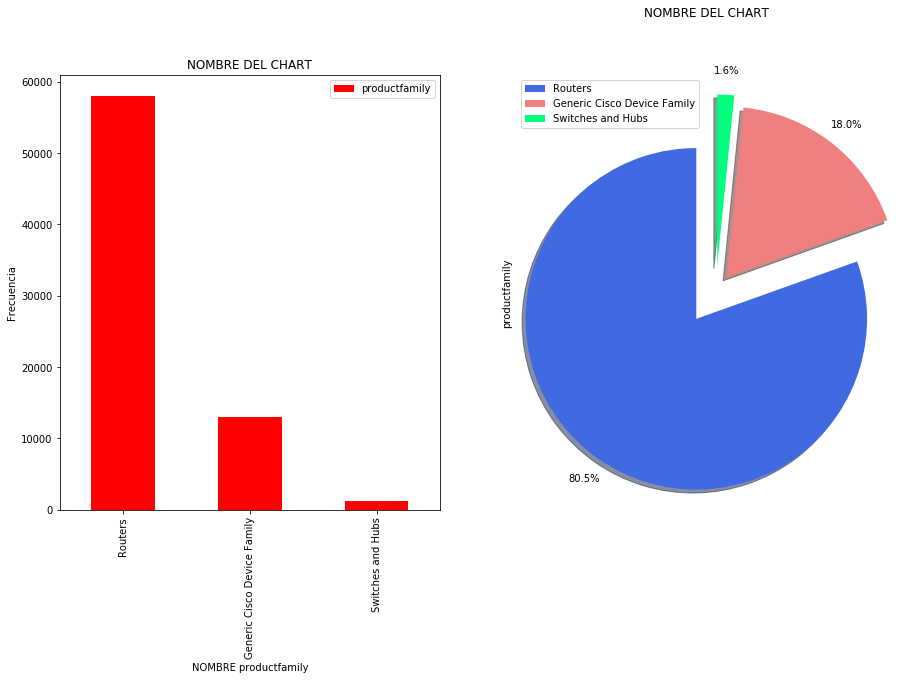

In [17]:
#Revisamos frecuencias:
campo_productfamily=pd.DataFrame(df.productfamily.value_counts())

#print campo_productfamily['productfamily'].size

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
campo_productfamily.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'NOMBRE productfamily')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'NOMBRE DEL CHART')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
#explode_list=[.2,0,0,0,0,0.1,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
explode_list=[.2,0.1,0.15] #Cada entrada corresponde a un registro del catálogo

color_list=['royalblue','lightcoral','springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','silver','mediumaquamarine',
            'mediumblue','mediumorchid','turquoise','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','powderblue']

campo_productfamily['productfamily'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'NOMBRE DEL CHART',y=1.12)
ax1.axis('equal')
ax1.legend(labels=campo_productfamily.index,loc='upper left')

plt.show()

Podemos observar en primer lugar, que se necesitan reglas de limpieza, existen outliers que al parecer son datos sucios.
Se llamará al catálogo limpio en el apartado de catálogos.

### Segundo catálogo: *softwaretype*

El siguiente catálogo es softwaretype. Este catalogo nos permite concer y agrupar los datos por medio de la familia del tipo de software. Este catálogo será llamado después en el apartado de catálogos. Nuestra intención por el momento es simplemente explorar los datos.

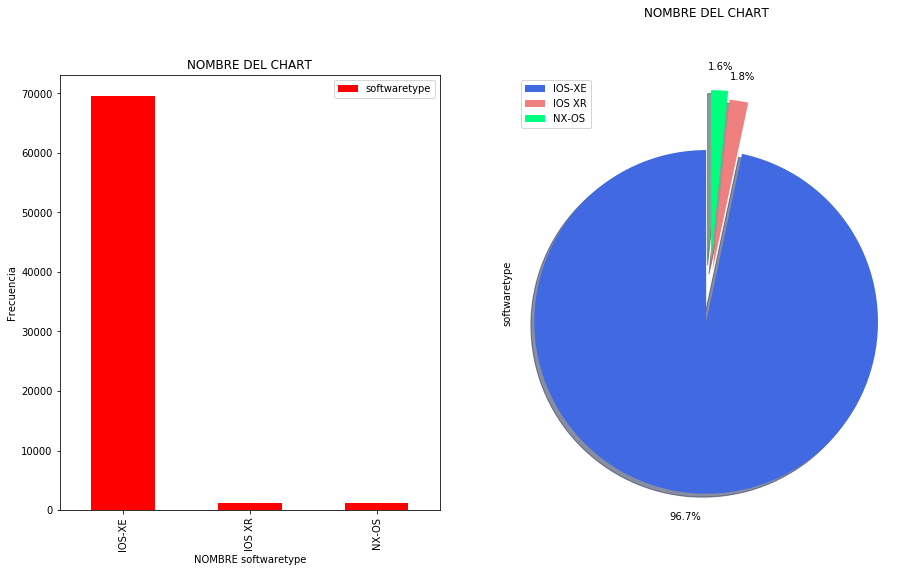

In [18]:
#Revisamos frecuencias:
campo_softwaretype=pd.DataFrame(df.softwaretype.value_counts())

#print campo_softwaretype['softwaretype'].size
#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
campo_softwaretype.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'NOMBRE softwaretype')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'NOMBRE DEL CHART')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
#explode_list=[.2,0,0,0,0,0.1,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
explode_list=[.2,0.1,0.15] #Cada entrada corresponde a un registro del catálogo

color_list=['royalblue','lightcoral','springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','silver','mediumaquamarine',
            'mediumblue','mediumorchid','turquoise','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','powderblue']

campo_softwaretype['softwaretype'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'NOMBRE DEL CHART',y=1.12)
ax1.axis('equal')
ax1.legend(labels=campo_softwaretype.index,loc='upper left')

plt.show()

### Tercer catálogo: *managementstatus*

El siguiente catálogo es managementstatus. Este catalogo nos permite concer y agrupar los datos por medio del estado. Este catálogo será llamado después en el apartado de catálogos. Nuestra intención por el momento es simplemente explorar los datos.

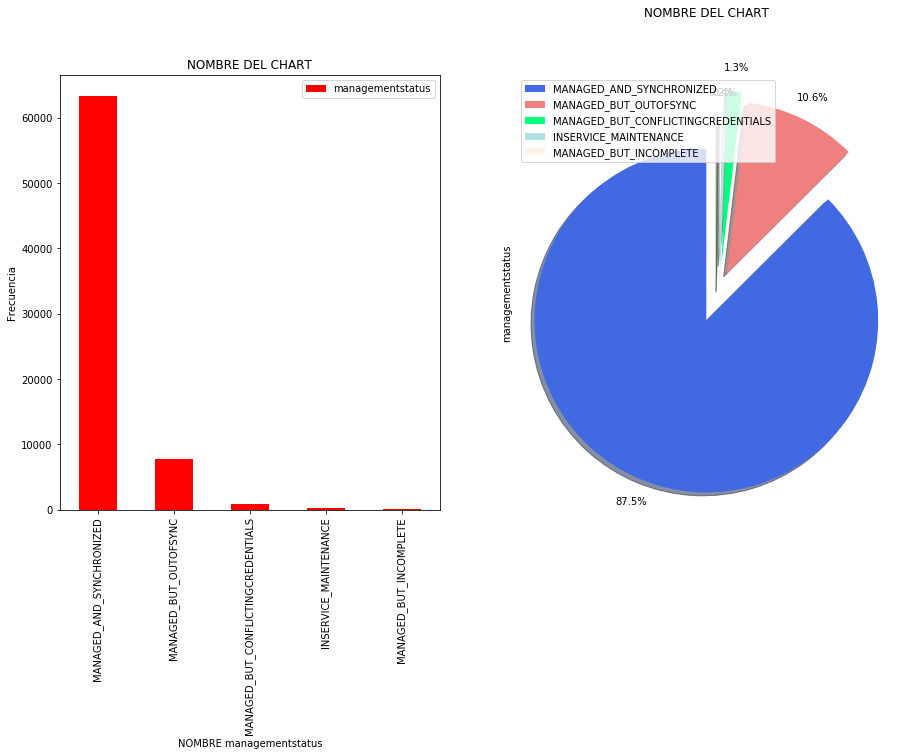

In [19]:
#Revisamos frecuencias:
campo_managementstatus=pd.DataFrame(df.managementstatus.value_counts())

#print campo_managementstatus['managementstatus'].size
#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
campo_managementstatus.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'NOMBRE managementstatus')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'NOMBRE DEL CHART')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
#explode_list=[.2,0,0,0,0,0.1,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
explode_list=[.2,0.1,0.15,0,0] #Cada entrada corresponde a un registro del catálogo

color_list=['royalblue','lightcoral','springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','silver','mediumaquamarine',
            'mediumblue','mediumorchid','turquoise','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','powderblue']

campo_managementstatus['managementstatus'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'NOMBRE DEL CHART',y=1.12)
ax1.axis('equal')
ax1.legend(labels=campo_managementstatus.index,loc='upper left')

plt.show()

#### Visualización de los datos de trazabilidad: 

Creamos una tabla donde se observarán los número de serie repetidos para un mejor análisis.

In [20]:
pd.DataFrame(df.serial_number.value_counts()[:15])

,serial_number
CAT1944U1S6,24
CAT2145U2WL,12
CAT1941U2ST,12
CAT1947U1PH,12
CAT2122U5BP,12
CAT2106U78T,12
CAT2122U5BW,12
CAT1947U1PQ,12
CAT2145U2WF,12
CAT2122U5B8,12


## 4 Calidad de los datos
Se documentará la calidad de los datos y analizará las variables que necesitan tratamiento con la ayuda de visualizaciones y tablas.

### Missings Values
Los missings values son los valores faltantes en el conjunto de datos que se refieren a aquellos campos que están vacíos o no tienen valores asignados, estos generalmente ocurren debido a errores de entrada de datos, fallas que ocurren con los procesos de recopilación de datos y, a menudo, al unir varias columnas de diferentes tablas encontramos una condición que conduce a valores faltantes. Existen numerosas formas de tratar los valores perdidos, los más fáciles son reemplazar el valor perdido con la media, la mediana, la moda o un valor constante (llegamos a un valor basado en el conocimiento del dominio) y otra alternativa es eliminar la entrada desde el conjunto de datos en sí.

Calculamos el porcentaje de NA's que tiene la fuente por columna y el porcentaje de los missings.

In [21]:
nas=df[relevantes].isna().sum()
porcentaje_nas=nas/df[relevantes].isna().count()

columnas=list(porcentaje_nas.keys())
counts_nas=list(porcentaje_nas.values)

#Para el siguiente comando, en el parámetro "color":
#Dependiendo el número de columnas se escoge un pallete, este debe ser cargado en la sección de librerías,
#Sólo se añade a la parte from bokeh.palettes import Category20c_20  colocando una ","
#http://docs.bokeh.org/en/1.3.2/docs/reference/palettes.html
#Se recomienda no poner más de 20 columnas. 
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_20))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1), title='Porcentaje de nas por columna')
p.vbar(x='columnas',top='counts_nas',width=.7, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(porcentaje_nas*100,columns=['Porcentaje de NAs'])

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('color', 20), ('columnas', 17), ('counts_nas', 17)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


,Porcentaje de NAs
omip,84.146370
productfamily,16.243702
creationtime,15.853630
nodename,84.146370
softwaretype,16.431772
managementstatus,15.853630
ipaddress,15.853630
devicename,16.243702
serial_number,84.146370
sheet_name,0.000000


#### Visualización de datos NOT NULL: 

In [22]:
notmiss=(1-porcentaje_nas)*100

columnas=list(notmiss.keys())
counts_nas=list(notmiss.values)

#Mismo aplica aquí para color
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_20))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,100), 
         title='Porcentaje de not-nulls por columna')
p.vbar(x='columnas',top='counts_nas',width=.5, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)

pd.DataFrame(notmiss,columns=['Porcentaje de Not nulls'])

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('color', 20), ('columnas', 17), ('counts_nas', 17)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


,Porcentaje de Not nulls
omip,15.853630
productfamily,83.756298
creationtime,84.146370
nodename,15.853630
softwaretype,83.568228
managementstatus,84.146370
ipaddress,84.146370
devicename,83.756298
serial_number,15.853630
sheet_name,100.000000


Se observa que en todas las columnas tienen cierto nivel de missings, pero los que destacan son omip,nodename,technology, manufacturerpartnr 

## 5. Catálogos

#### Catálogo de productfamily:

In [23]:
Catalogo_productfamily=pd.DataFrame(df.productfamily.unique())
Catalogo_productfamily.columns=['productfamily']

#Remover los sucios
#Esta parte depende del estado del catálogo, deben quedar sólamente los valores limpios, un ejemplo puede ser:
#Catalogo_CAMPO.drop(labels=[67,346,369,279,171,313],axis=0,inplace=True)

#Se le da 
Catalogo_productfamily.reset_index(drop=True)
Catalogo_productfamily.dropna(inplace=True)
Catalogo_productfamily.sort_values(by='productfamily').head(10)

,productfamily
0,Generic Cisco Device Family
1,Routers
2,Switches and Hubs


#### Catálogo de softwaretype:

In [24]:
Catalogo_softwaretype=pd.DataFrame(df.softwaretype.unique())
Catalogo_softwaretype.columns=['productfamily']

#Remover los sucios
#Esta parte depende del estado del catálogo, deben quedar sólamente los valores limpios, un ejemplo puede ser:
#Catalogo_CAMPO.drop(labels=[67,346,369,279,171,313],axis=0,inplace=True)

#Se le da 
Catalogo_softwaretype.reset_index(drop=True)
Catalogo_softwaretype.dropna(inplace=True)
Catalogo_softwaretype.sort_values(by='productfamily').head(10)

,productfamily
1,IOS XR
0,IOS-XE
2,NX-OS


#### Catálogo de managementstatus:

In [25]:
Catalogo_managementstatus=pd.DataFrame(df.managementstatus.unique())
Catalogo_managementstatus.columns=['managementstatus']

#Remover los sucios
#Esta parte depende del estado del catálogo, deben quedar sólamente los valores limpios, un ejemplo puede ser:
#Catalogo_CAMPO.drop(labels=[67,346,369,279,171,313],axis=0,inplace=True)

#Se le da 
Catalogo_managementstatus.reset_index(drop=True)
Catalogo_managementstatus.dropna(inplace=True)
Catalogo_managementstatus.sort_values(by='managementstatus').head(10)

,managementstatus
3,INSERVICE_MAINTENANCE
0,MANAGED_AND_SYNCHRONIZED
1,MANAGED_BUT_CONFLICTINGCREDENTIALS
4,MANAGED_BUT_INCOMPLETE
2,MANAGED_BUT_OUTOFSYNC


**Carina:Lo mismo de hace rato, sólo considerar el primer catalogo y omitir los otros**

## 6. Preparación de los datos
Para la preparación de los datos crearemos las reglas de calidad o estándares observados en el apartado anterior de acuerdo a la calidad de datos obtenidos: 

* **serie:**
    * Homologar formatos en los casos posibles. 
    * Se marcan como *np.NaN* : campos que contengan:
        * ESPACIOS
        * La palabra BORRADO
        * La palabra VICIBLE
        * La palabra VISIBLE
        * CARACTER ESPECIAL
        * ILEGIBLE
        * INCOMPLETO
        * Registros que sean completamente alfabéticos.

* **marca**: REGLA DE LIMPIEZA.
    * Se eliminan los siguientes caracteres especiales:    '-','#','%','/','_'
    * replace('ALACATEL LUCENT','ALCATEL LUCENT')
    * replace('ALCATEL . LUCENT','ALCATEL LUCENT')
    * replace('ALCATEL TLUCEN','ALCATEL LUCENT')
    * replace('ALCATEL.LUCENT','ALCATEL LUCENT')
    * replace('A 10','A10')
    * replace('ALCATEL-LUNCENT','ALCATEL LUCENT')
    * replace(especiales,' ',)

* Pasar todo a uppercase

In [26]:
df['trazabilidad']=0
df.trazabilidad.loc[(df.serie_cleaned==0) ]=1
#CS CA
df['CS_CA']=0
df.CS_CA.loc[(df.serie_cleaned==0) ]=1
#CS SA
df['CS_SA']=0
df.CS_SA.loc[(df.serie_cleaned==0) ]=1
#SS CA
df['SS_CA']=0
df.SS_CA.loc[(df.serie_cleaned==1) ]=1

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [27]:
df.dtypes

omip                   object
productfamily          object
creationtime           object
nodename               object
softwaretype           object
managementstatus       object
ipaddress              object
devicename             object
serial_number          object
sheet_name             object
technology             object
manufacturerpartnr     object
adminstatus            object
location               object
reachability           object
devicetypeparameter    object
filedate                int64
filename               object
hash_id                object
sourceid               object
registry_state         object
datasetname            object
timestamp               int64
transaction_status     object
year                    int64
month                   int64
day                     int64
serie_cleaned           int64
trazabilidad            int64
CS_CA                   int64
CS_SA                   int64
SS_CA                   int64
dtype: object

In [28]:
mySchema = StructType([ StructField("omip", StringType(), True)\
                       ,StructField("productfamily", StringType(), True)\
                       ,StructField("creationtime", StringType(), True)\
                       ,StructField("nodename", StringType(), True)\
                       ,StructField("softwaretype", StringType(), True)\
                       ,StructField("managementstatus", StringType(), True)\
                       ,StructField("ipaddress", StringType(), True)\
                       ,StructField("devicename", StringType(), True)\
                       ,StructField("serial_number", StringType(), True)\
                       ,StructField("sheet_name", StringType(), True)\
                       ,StructField("technology", StringType(), True)\
                       ,StructField("manufacturerpartnr", StringType(), True)\
                       ,StructField("adminstatus", StringType(), True)\
                       ,StructField("location", StringType(), True)\
                       ,StructField("reachability", StringType(), True)\
                       ,StructField("devicetypeparameter", StringType(), True)\
                       ,StructField("filedate", IntegerType(), True)\
                       ,StructField("filename", StringType(), True)\
                       ,StructField("hash_id", StringType(), True)\
                       ,StructField("sourceid", StringType(), True)\
                       ,StructField("registry_state", StringType(), True)\
                       ,StructField("datasetname", StringType(), True)\
                       ,StructField("timestamp", IntegerType(), True)\
                       ,StructField("transaction_status", StringType(), True)\
                       ,StructField("year", IntegerType(), True)\
                       ,StructField("month", IntegerType(), True)\
                       ,StructField("day", IntegerType(), True)\
                       ,StructField("serie_cleaned", IntegerType(), True)\
                       ,StructField("trazabilidad", IntegerType(), True)\
                       ,StructField("CS_CA", IntegerType(), True)\
                       ,StructField("CS_SA", IntegerType(), True)\
                       ,StructField("SS_CA", IntegerType(), True)])

In [29]:
#df_hive_tx_netcm_cisco_epn = spark.createDataFrame(df,schema=mySchema)

In [30]:
#df_hive_tx_netcm_cisco_epn.write.mode("overwrite").saveAsTable("default.eda_tx_netcm_cisco_epn")


## 7 Métricas KPI

Se mostrarán los KPIs generados. 

In [31]:
Total_Elementos=df.shape[0]
Total_Elementos

86138

In [32]:
df.replace(np.NaN,'vacio',inplace=True)

#### Total Elementos Trazables

In [33]:
Total_Tr=df.loc[(df.serial_number!='vacio') ].shape[0]
Total_Tr

13656

#### Total Elementos NO Trazables

In [34]:
Total_NOTr=Total_Elementos-Total_Tr
Total_NOTr

72482

#### Total Elementos Trazables Únicos

In [35]:
Total_Tr_Unic=df[['serial_number']].loc[(df.serial_number!='vacio') ].drop_duplicates().shape[0]
Total_Tr_Unic

1137

#### Total de elementos trazables duplicados

In [36]:
Total_Tr_Dupli=Total_Tr-Total_Tr_Unic
Total_Tr_Dupli

12519

In [37]:
df.columns

Index([u'omip', u'productfamily', u'creationtime', u'nodename',
       u'softwaretype', u'managementstatus', u'ipaddress', u'devicename',
       u'serial_number', u'sheet_name', u'technology', u'manufacturerpartnr',
       u'adminstatus', u'location', u'reachability', u'devicetypeparameter',
       u'filedate', u'filename', u'hash_id', u'sourceid', u'registry_state',
       u'datasetname', u'timestamp', u'transaction_status', u'year', u'month',
       u'day', u'serie_cleaned', u'trazabilidad', u'CS_CA', u'CS_SA',
       u'SS_CA'],
      dtype='object')

### EN CASO DE EXISTIR NOMBRE DE ALMACENES:

#### Total de elementos en almacén Trazables Únicos en NOMBREALMACEN

In [38]:
NOMBREALMACEN_Tr_Unic=df[['serial_number']].loc[((df.serial_number!='vacio') )].drop_duplicates().shape[0]
NOMBREALMACEN_Tr_Unic

1137

#### Total de elementos en almacén Trazables Únicos con NSerie, con Nactivo

In [39]:
Total_Tr_Unic_CS_CA=df[['serial_number']].loc[(df.serial_number!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_CS_CA

1137

#### Total de elementos en almacén Trazables Únicos con NSerie, sin Nactivo 

In [40]:
Total_Tr_Unic_CS_SA=df[['serial_number']].loc[(df.serial_number!='vacio') ].drop_duplicates().shape[0]
Total_Tr_Unic_CS_SA

1137

#### Total de elementos en almacén Trazables Únicos sin NSerie, con Nactivo

In [41]:
Total_Tr_Unic_SS_CA=df[['serial_number']].loc[(df.serial_number=='vacio') ].drop_duplicates().shape[0]
Total_Tr_Unic_SS_CA

1

### KPIS

In [42]:
#Ajustar el df contra los kpis de la siguiente tabla:

KPIs=pd.DataFrame({'KPI':['Total Elementos','Total Elementos Trazables',
                         'Total NO Trazables','Total Trazables Unicos',
                         'Total Trazables Duplicados',
                          'Total CS CA','Total CS SA','Total SS CA'],
                  'Resultado':[Total_Elementos,Total_Tr,Total_NOTr,
                              Total_Tr_Unic,Total_Tr_Dupli,
                               Total_Tr_Unic_CS_CA,Total_Tr_Unic_CS_SA,
                              Total_Tr_Unic_SS_CA]})

KPIs

,KPI,Resultado
0,Total Elementos,86138
1,Total Elementos Trazables,13656
2,Total NO Trazables,72482
3,Total Trazables Unicos,1137
4,Total Trazables Duplicados,12519
5,Total CS CA,1137
6,Total CS SA,1137
7,Total SS CA,1


## 1.2 NETCM ERICSSON 

### Recolección de los datos:

Se crea el dataframe de spark



In [43]:
df_load_2 =spark.sql("SELECT * FROM tx_netcm_ericsson where year = 2019 and month=11").cache()#.toPandas() 

In [44]:
df_load_1_2019_10 = df_load_2.withColumn("serie_cleaned",validate_rule_udf(col("serialnumber"))).cache()

Se carga a pandas

In [45]:
df_1 = df_load_1_2019_10.toPandas()

### Gestor NETCM ERICSSON


Una muestra de la fuente tx_netcm_ericsson


In [46]:
df_1.head(5)

,site,ru,operstate,rnc,antennaserialnumber,node,rurevision,maxsupportedelectricaltilt,bootrom,state,...,hash_id,sourceid,registry_state,datasetname,timestamp,transaction_status,year,month,day,serie_cleaned
0,CHHJRZ0146,2,,,,,1/BFL 901 009/4 R2B,,,OPER,...,545b2046fe000aa9a593211fca2658c1b1b0476fb93428...,Gestores-NETCM,2019:10:27:17:57:27,tx_netcm_ericsson,20191127,full,2019,11,16,0
1,CHHJRZ0146,0 & 5 & 6,,,,,KRC 161 299/2 R1M,,,OPER & OPER & OPER & OPER & OPER,...,545b2046fe000aa9a593211fca2658c1b1b0476fb93428...,Gestores-NETCM,2019:10:27:17:57:27,tx_netcm_ericsson,20191127,full,2019,11,16,0
2,CHHJRZ0146,0 & 7 & 8,,,,,KRC 161 299/2 R1M,,,OPER & OPER & OPER & OPER & OPER,...,545b2046fe000aa9a593211fca2658c1b1b0476fb93428...,Gestores-NETCM,2019:10:27:17:57:27,tx_netcm_ericsson,20191127,full,2019,11,16,0
3,CHHJRZ0146,0 & 3 & 4,,,,,KRC 161 299/2 R1M,,,OPER & OPER & OPER & OPER & OPER,...,545b2046fe000aa9a593211fca2658c1b1b0476fb93428...,Gestores-NETCM,2019:10:27:17:57:27,tx_netcm_ericsson,20191127,full,2019,11,16,0
4,CHHJRZ0146,1,,,,,527/BFL 901 009 R1A,,,OPER,...,545b2046fe000aa9a593211fca2658c1b1b0476fb93428...,Gestores-NETCM,2019:10:27:17:57:27,tx_netcm_ericsson,20191127,full,2019,11,16,0


In [47]:
df_1.columns

Index([u'site', u'ru', u'operstate', u'rnc', u'antennaserialnumber', u'node',
       u'rurevision', u'maxsupportedelectricaltilt', u'bootrom', u'state',
       u'btsswver', u'eq_class', u'f_timestamp', u'rulogicalid', u'adminstate',
       u'productname', u'bsc', u'productiondate', u'prodname',
       u'minsupportedelectricaltilt', u'electricalantennatilt', u'powerstate',
       u'tg_count', u'productrevision', u'serialno', u'ruserialno_count',
       u'mo', u'serialnumber', u'antennamodelnumber', u'prodno', u'ruserialno',
       u'productnumber', u'eq', u'nodeb', u'sheet_name', u'type', u'manweek',
       u'tg', u'revision', u'fsbrole', u'enodeb', u'filedate', u'filename',
       u'hash_id', u'sourceid', u'registry_state', u'datasetname',
       u'timestamp', u'transaction_status', u'year', u'month', u'day',
       u'serie_cleaned'],
      dtype='object')

In [48]:
df_1["bootrom"].unique

<bound method Series.unique of 0          
1          
2          
3          
4          
5          
6          
7          
8          
9          
10         
11         
12         
13         
14         
15         
16         
17         
18         
19         
20         
21         
22         
23         
24         
25         
26         
27         
28         
29         
         ..
360281     
360282     
360283     
360284     
360285     
360286     
360287     
360288     
360289     
360290     
360291     
360292     
360293     
360294     
360295     
360296     
360297     
360298     
360299     
360300     
360301     
360302     
360303     
360304     
360305     
360306     
360307     
360308     
360309     
360310     
Name: bootrom, Length: 360311, dtype: object>

### Diccionario de datos.

A continuación se enlistan los campos de la fuente con una breve descripción de negocio.



* **site**: Sitio.
* **operstate**: Pendiente.
* **rnc**: Pendiente.
* **antennaserialnumber**: Numero de seria de la antena.
* **node**: Nodo.
* **rurevision**: Pendiente.
* **maxsupportedelectricaltilt**: Maximo soporte electrico.
* **bootrom**: Pendiente.
* **state**: Estado.
* **btsswver**: Pendiente.
* **eq_class**: Pendiente.
* **f_timestamp**: Fecha y hora.
* **rulogicalid**: Pendiente, podria ser un id.
* **adminstate**: Estado de admin.
* **productname**: Nombre de producto.
* **bsc**: Pendiente.
* **productiondate**: Fecha del producto.
* **prodname**: Nombre del producto.
* **minsupportedelectricaltilt**: Pendiente.
* **electricalantennatilt**: Pendiente.
* **powerstate**: Estado de la carga
* **tg_count**: Conteo
* **productrevision**: Revision de producto
* **serialno**: Serial
* **ruserialno_count**: Conteo de serial
* **mo**: Pendiente
* **serialnumber**: Numero de serie
* **antennamodelnumber**: Numero del modelo de antena
* **ruserialno**: Pendiente.
* **productnumber**: Numero de producto
* **eq**: Pendiente
* **nodeb**: Pendiente.
* **sheet_name**: Nombre del sheet.
* **type**: Tipo.
* **manweek**: Pendiente.
* **tg**: Pendiente.
* **revision**: Revision.
* **fsbrole**: Pendiente.
* **filedate**: Fecha de carga del archivo fuente.
* **filename**: Nombre del archivo fuente.
* **hash_id**: Identificador único hash de la fuente.
* **sourceid**: Fuente de archivo.
* **registry_state**: Timestamp de carga.
* **datasetname**: Nombre indentificador de la fuente.
* **timestamp**: Fecha de carga.
* **transaction_status**: Estatus de registro.
* **year**: Año de la partición.
* **month**: Mes de la partición.
* **day**: Día de la partición.


## 2.1 Descripción de las fuentes

En este apartado se hará una descripción a detalle de las fuentes para una mejor comprensión de los datos. Por cada fuente se mostrarán los tipos de datos, tamaño de la fuente, es decir, su dimensionalidad y una estadística descriptiva, en ese orden.

In [49]:
campos_1=df_1.columns
print('Columnas de la fuente SOURCE son: ',list(campos_1))
pd.DataFrame(df_1.dtypes,columns=['Tipo de objeto SOURCE'])

('Columnas de la fuente SOURCE son: ', ['site', 'ru', 'operstate', 'rnc', 'antennaserialnumber', 'node', 'rurevision', 'maxsupportedelectricaltilt', 'bootrom', 'state', 'btsswver', 'eq_class', 'f_timestamp', 'rulogicalid', 'adminstate', 'productname', 'bsc', 'productiondate', 'prodname', 'minsupportedelectricaltilt', 'electricalantennatilt', 'powerstate', 'tg_count', 'productrevision', 'serialno', 'ruserialno_count', 'mo', 'serialnumber', 'antennamodelnumber', 'prodno', 'ruserialno', 'productnumber', 'eq', 'nodeb', 'sheet_name', 'type', 'manweek', 'tg', 'revision', 'fsbrole', 'enodeb', 'filedate', 'filename', 'hash_id', 'sourceid', 'registry_state', 'datasetname', 'timestamp', 'transaction_status', 'year', 'month', 'day', 'serie_cleaned'])


,Tipo de objeto SOURCE
site,object
ru,object
operstate,object
rnc,object
antennaserialnumber,object
node,object
rurevision,object
maxsupportedelectricaltilt,object
bootrom,object
state,object


In [50]:
print('renglones = ',df_1.shape[0],' columnas = ',df_1.shape[1])


('renglones = ', 360311, ' columnas = ', 53)


In [51]:
#Pasamos las columnas que queremos ver en nuestro describe:
NOrelevantes_1=['filedate', 'filename', 'hash_id', 'sourceid',
              'registry_state', 'datasetname', 'timestamp',
              'transaction_status', 'year', 'month', 'day']
relevantes_1=[v for v in df_1.columns if v not in NOrelevantes_1]

df_1[relevantes_1].describe(include='all')

,site,ru,operstate,rnc,antennaserialnumber,node,rurevision,maxsupportedelectricaltilt,bootrom,state,...,eq,nodeb,sheet_name,type,manweek,tg,revision,fsbrole,enodeb,serie_cleaned
count,360311,360311,360311,360311,360311,360311,360311,360311,360311,360311,...,360311,360311,360311,360311,360311,360311,360311,360311,360311,360311.000000
unique,242,15,2,13,3044,3,32,13,3,24,...,43,1854,8,4,18,185,4,4,945,NaN
top,,,,,,,,100,,,...,,,Ericsson BTS - Antenna Serial N,,,,,,,NaN
freq,335451,335451,358631,131716,131716,358631,335451,136986,358631,335451,...,358631,131716,182803,358631,358631,335451,358631,358631,255135,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291792
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.454588
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [52]:
df_1["antennamodelnumber"].unique()


array([u'', u'80010510V01_B1', u'80010510V01_B2', u'NULL', u'HBXX3319DS',
       u'HBXX6516DS', u'HBXXX6516DS', u'2V65R18K-R', u'3V65R18K-T',
       u'3V65R18K-B', u'3V65R18K-M', u'2V65R18K-L', u'80010510V01',
       u'80010510V01_R', u'HBXX3817TB1', u'HBXX6516D5', u'HBX6513DS',
       u'80010622V01_Y2', u'80010622V01_Y1', u'ODI2-065R18K-GQ',
       u'HBXX6513DS', u'OPA65R-W4A-HW01', u'80010510V01_L',
       u'ODI3-065R18K-GQ', u'80010727_Y3', u'80010727_Y2', u'80010727_Y1',
       u'RVV-33B-R3', u'?????}z????????', u'???????????????'],
      dtype=object)

#### Haremos anotaciones sobre lo que se puede observar de la tabla describe:

* Como se puede observar las columnas que mas se adecuan para ser un catalogo son rnc,node, type y revision, ya que son columnas que nos proporciona una forma de clasificacion y agrupacion del set de datos , y son columnas que pueden agregar cierto valor al negocio, solo se tiene que conocer bien el conexto, por  ejemplo la revision, el nodo, etc.

## 3.1 Exploración de los datos

#### Para empezar, se hará una limpieza general a los datos:

In [53]:
df_1.replace('null',np.NaN,inplace=True)
df_1.replace('NA',np.NaN,inplace=True)
df_1.replace('na',np.NaN,inplace=True)
df_1.replace('NULL',np.NaN,inplace=True)
df_1.replace('<NULL>',np.NaN,inplace=True)
df_1.replace(' ',np.NaN,inplace=True)
df_1.replace('',np.NaN,inplace=True)

### Primer catálogo: rnc

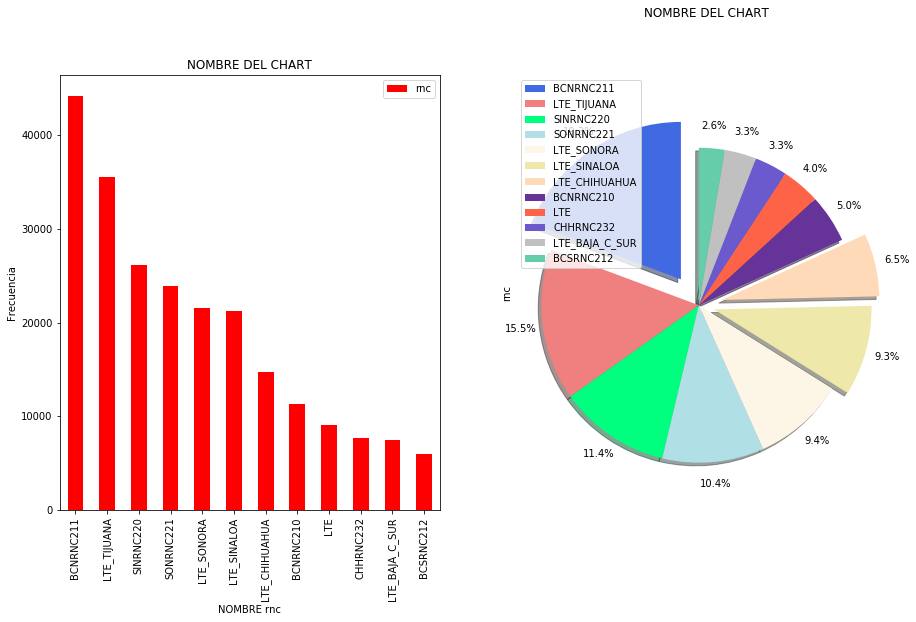

In [54]:
#Revisamos frecuencias:
campo_rnc =pd.DataFrame(df_1.rnc.value_counts())
#print campo_rnc['rnc'].size

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
campo_rnc.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'NOMBRE rnc')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'NOMBRE DEL CHART')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
#explode_list=[.2,0,0,0,0,0.1,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
explode_list=[.2,0,0,0,0,0.1,0.15,0,0,0,0,0] #Cada entrada corresponde a un registro del catálogo

color_list=['royalblue','lightcoral','springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','silver','mediumaquamarine',
            'mediumblue','mediumorchid','turquoise','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','powderblue']

campo_rnc['rnc'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'NOMBRE DEL CHART',y=1.12)
ax1.axis('equal')
ax1.legend(labels=campo_rnc.index,loc='upper left')

plt.show()


### Segundo catálogo: type

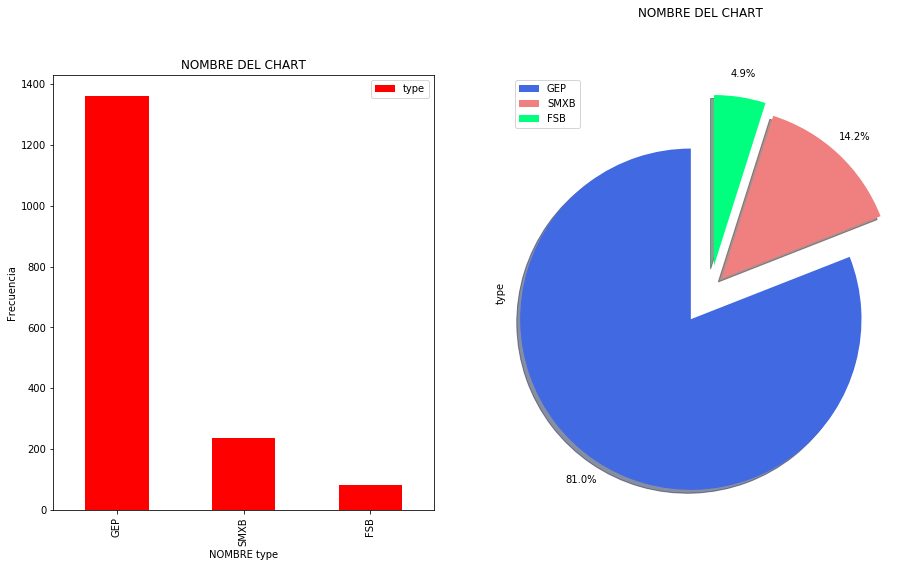

In [55]:
campo_type=pd.DataFrame(df_1.type.value_counts())

#print campo_type['type'].size
#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
campo_type.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'NOMBRE type')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'NOMBRE DEL CHART')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
#explode_list=[.2,0,0,0,0,0.1,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
explode_list=[.2,0.1,0.15] #Cada entrada corresponde a un registro del catálogo

color_list=['royalblue','lightcoral','springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','silver','mediumaquamarine',
            'mediumblue','mediumorchid','turquoise','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','powderblue']

campo_type['type'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'NOMBRE DEL CHART',y=1.12)
ax1.axis('equal')
ax1.legend(labels=campo_type.index,loc='upper left')

plt.show()

#### Visualización de los datos de trazabilidad:

In [56]:
pd.DataFrame(df_1.serialnumber.value_counts()[:15])


,serialnumber
A530000003,100
CH40152173,40
TU8XZ65942,40
TU8XW69574,40
BR84749894,40
TU8XZ65840,40
TU8XZ65841,40
TU8XZ14882,40
CH40147665,40
TU8XZ65929,40


## 4.1 Calidad de los datos

Se documentará la calidad de los datos y analizará las variables que necesitan tratamiento con la ayuda de visualizaciones y tablas.

### Missings Values

Los missings values son los valores faltantes en el conjunto de datos que se refieren a aquellos campos que están vacíos o no tienen valores asignados, estos generalmente ocurren debido a errores de entrada de datos, fallas que ocurren con los procesos de recopilación de datos y, a menudo, al unir varias columnas de diferentes tablas encontramos una condición que conduce a valores faltantes. Existen numerosas formas de tratar los valores perdidos, los más fáciles son reemplazar el valor perdido con la media, la mediana, la moda o un valor constante (llegamos a un valor basado en el conocimiento del dominio) y otra alternativa es eliminar la entrada desde el conjunto de datos en sí.

Calculamos el porcentaje de NA's que tiene la fuente por columna y el porcentaje de los missings.

In [57]:
nas=df_1[relevantes_1].isna().sum()
porcentaje_nas=nas/df_1[relevantes_1].isna().count()

columnas=list(porcentaje_nas.keys())
counts_nas=list(porcentaje_nas.values)

#Para el siguiente comando, en el parámetro "color":
#Dependiendo el número de columnas se escoge un pallete, este debe ser cargado en la sección de librerías,
#Sólo se añade a la parte from bokeh.palettes import Category20c_20  colocando una ","
#http://docs.bokeh.org/en/1.3.2/docs/reference/palettes.html
#Se recomienda no poner más de 20 columnas. 
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_20))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1), title='Porcentaje de nas por columna')
p.vbar(x='columnas',top='counts_nas',width=.7, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(porcentaje_nas*100,columns=['Porcentaje de NAs'])

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('color', 20), ('columnas', 42), ('counts_nas', 42)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


,Porcentaje de NAs
site,93.100405
ru,93.100405
operstate,99.533736
rnc,36.556197
antennaserialnumber,62.695005
node,99.533736
rurevision,93.105956
maxsupportedelectricaltilt,36.556197
bootrom,99.533736
state,93.100405


Visualización de datos NOT NULL:

In [58]:
notmiss=(1-porcentaje_nas)*100

columnas=list(notmiss.keys())
counts_nas=list(notmiss.values)

#Mismo aplica aquí para color
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_20))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,100), 
         title='Porcentaje de not-nulls por columna')
p.vbar(x='columnas',top='counts_nas',width=.5, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)

pd.DataFrame(notmiss,columns=['Porcentaje de Not nulls'])

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('color', 20), ('columnas', 42), ('counts_nas', 42)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


,Porcentaje de Not nulls
site,6.899595
ru,6.899595
operstate,0.466264
rnc,63.443803
antennaserialnumber,37.304995
node,0.466264
rurevision,6.894044
maxsupportedelectricaltilt,63.443803
bootrom,0.466264
state,6.899595


##  5.1 Catálogos

#### Catálogo de rnc:


In [59]:
Catalogo_rnc=pd.DataFrame(df_1.rnc.unique())
Catalogo_rnc.columns=['rnc']

#Remover los sucios
#Esta parte depende del estado del catálogo, deben quedar sólamente los valores limpios, un ejemplo puede ser:
#Catalogo_CAMPO.drop(labels=[67,346,369,279,171,313],axis=0,inplace=True)

#Se le da 
Catalogo_rnc.reset_index(drop=True)
Catalogo_rnc.dropna(inplace=True)
Catalogo_rnc.sort_values(by='rnc').head(10)

,rnc
11,BCNRNC210
7,BCNRNC211
12,BCSRNC212
8,CHHRNC232
2,LTE
3,LTE_BAJA_C_SUR
4,LTE_CHIHUAHUA
5,LTE_SINALOA
6,LTE_SONORA
1,LTE_TIJUANA


#### Catálogo de node:

In [60]:
Catalogo_node=pd.DataFrame(df_1.node.unique())
Catalogo_node.columns=['node']

#Remover los sucios
#Esta parte depende del estado del catálogo, deben quedar sólamente los valores limpios, un ejemplo puede ser:
#Catalogo_CAMPO.drop(labels=[67,346,369,279,171,313],axis=0,inplace=True)

#Se le da 
Catalogo_node.reset_index(drop=True)
Catalogo_node.dropna(inplace=True)
Catalogo_node.sort_values(by='node').head(10)

,node
2,MXPTLM01SGSNMME01
1,MXTIJM01SGSNMME01


#### Catálogo de type:


In [61]:
Catalogo_type=pd.DataFrame(df_1.type.unique())
Catalogo_type.columns=['type']

#Remover los sucios
#Esta parte depende del estado del catálogo, deben quedar sólamente los valores limpios, un ejemplo puede ser:
#Catalogo_CAMPO.drop(labels=[67,346,369,279,171,313],axis=0,inplace=True)

#Se le da 
Catalogo_type.reset_index(drop=True)
Catalogo_type.dropna(inplace=True)
Catalogo_type.sort_values(by='type').head(10)

,type
2,FSB
1,GEP
3,SMXB


In [62]:
#df_serie_cleaned_2 = df_1.loc[df_1["serie_cleaned"]== 1]


In [63]:
#df_serie_cleaned_2.to_excel("clean_tx_netcm_ericsson_2019_11.xlsx") 


## 6.1 Preparación de los datos

Para la preparación de los datos crearemos las reglas de calidad o estándares observados en el apartado anterior de acuerdo a la calidad de datos obtenidos: 


* **serie:**
    * Homologar formatos en los casos posibles. 
    * Se marcan como *np.NaN* : campos que contengan:
        * ESPACIOS
        * La palabra BORRADO
        * La palabra VICIBLE
        * La palabra VISIBLE
        * CARACTER ESPECIAL
        * ILEGIBLE
        * INCOMPLETO
        * Registros que sean completamente alfabéticos.

* **marca**: REGLA DE LIMPIEZA.
    * Se eliminan los siguientes caracteres especiales:    '-','#','%','/','_'
    * replace('ALACATEL LUCENT','ALCATEL LUCENT')
    * replace('ALCATEL . LUCENT','ALCATEL LUCENT')
    * replace('ALCATEL TLUCEN','ALCATEL LUCENT')
    * replace('ALCATEL.LUCENT','ALCATEL LUCENT')
    * replace('A 10','A10')
    * replace('ALCATEL-LUNCENT','ALCATEL LUCENT')
    * replace(especiales,' ',)
    * Pasar todo a uppercase


In [64]:
df_1['trazabilidad']=0
df_1.trazabilidad.loc[(df_1.serie_cleaned==0) ]=1
#CS CA
df_1['CS_CA']=0
df_1.CS_CA.loc[(df_1.serie_cleaned==0) ]=1
#CS SA
df_1['CS_SA']=0
df_1.CS_SA.loc[(df_1.serie_cleaned==0) ]=1
#SS CA
df_1['SS_CA']=0
df_1.SS_CA.loc[(df_1.serie_cleaned==1) ]=1

In [65]:
df_1.dtypes

site                          object
ru                            object
operstate                     object
rnc                           object
antennaserialnumber           object
node                          object
rurevision                    object
maxsupportedelectricaltilt    object
bootrom                       object
state                         object
btsswver                      object
eq_class                      object
f_timestamp                   object
rulogicalid                   object
adminstate                    object
productname                   object
bsc                           object
productiondate                object
prodname                      object
minsupportedelectricaltilt    object
electricalantennatilt         object
powerstate                    object
tg_count                      object
productrevision               object
serialno                      object
ruserialno_count              object
mo                            object
s

In [66]:
mySchema_1 = StructType([ StructField("site", StringType(), True)\
                       ,StructField("ru", StringType(), True)\
                       ,StructField("operstate", StringType(), True)\
                       ,StructField("rnc", StringType(), True)\
                       ,StructField("antennaserialnumber", StringType(), True)\
                       ,StructField("node", StringType(), True)\
                       ,StructField("rurevision", StringType(), True)\
                       ,StructField("maxsupportedelectricaltilt", StringType(), True)\
                       ,StructField("bootrom", StringType(), True)\
                       ,StructField("state", StringType(), True)\
                       ,StructField("btsswver", StringType(), True)\
                       ,StructField("eq_class", StringType(), True)\
                       ,StructField("f_timestamp", StringType(), True)\
                       ,StructField("rulogicalid", StringType(), True)\
                       ,StructField("adminstate", StringType(), True)\
                       ,StructField("productname", StringType(), True)\
                       ,StructField("bsc", StringType(), True)\
                       ,StructField("productiondate", StringType(), True)\
                       ,StructField("prodname", StringType(), True)\
                       ,StructField("minsupportedelectricaltilt", StringType(), True)\
                       ,StructField("electricalantennatilt", StringType(), True)\
                       ,StructField("powerstate", StringType(), True)\
                       ,StructField("tg_count", StringType(), True)\
                       ,StructField("productrevision", StringType(), True)\
                       ,StructField("serialno", StringType(), True)\
                         ,StructField("ruserialno_count", StringType(), True)\
                         ,StructField("mo", StringType(), True)\
                         ,StructField("serialnumber", StringType(), True)\
                         ,StructField("antennamodelnumber", StringType(), True)\
                         ,StructField("prodno", StringType(), True)\
                         ,StructField("ruserialno", StringType(), True)\
                         ,StructField("productnumber", StringType(), True)\
                         ,StructField("eq", StringType(), True)\
                         ,StructField("nodeb", StringType(), True)\
                         ,StructField("sheet_name", StringType(), True)\
                         ,StructField("type", StringType(), True)\
                         ,StructField("manweek", StringType(), True)\
                         ,StructField("tg", StringType(), True)\
                         ,StructField("revision", StringType(), True)\
                         ,StructField("fsbrole", StringType(), True)\
                         ,StructField("enodeb", StringType(), True)\
                         ,StructField("filedate", StringType(), True)\
                         ,StructField("filename", StringType(), True)\
                         ,StructField("hash_id", StringType(), True)\
                         ,StructField("sourceid", StringType(), True)\
                         ,StructField("registry_state", StringType(), True)\
                         ,StructField("datasetname", StringType(), True)\
                         ,StructField("timestamp", IntegerType(), True)\
                         ,StructField("transaction_status", StringType(), True)\
                         ,StructField("year", IntegerType(), True)\
                         ,StructField("month", IntegerType(), True)\
                         ,StructField("day", IntegerType(), True)\
                         ,StructField("serie_cleaned", IntegerType(), True)\
                         ,StructField("trazabilidad", IntegerType(), True)\
                         ,StructField("CS_CA", IntegerType(), True)\
                         ,StructField("CS_SA", IntegerType(), True)\
                         ,StructField("SS_CA", IntegerType(), True)])

In [67]:
#df_hive_tx_netcm_ericsson = spark.createDataFrame(df_1,schema=mySchema_1)


In [68]:
#df_hive_tx_netcm_ericsson.write.mode("overwrite").saveAsTable("default.eda_tx_netcm_ericsson")


##  7.1 Métricas KPI

Se mostrarán los KPIs generados.

#### Total de elementos:

In [69]:
Total_Elementos=df_1.shape[0]
Total_Elementos

360311

In [70]:
df_1.replace(np.NaN,'vacio',inplace=True)

#### Total Elementos Trazables

In [71]:
Total_Tr=df_1.loc[(df_1.serialnumber!='vacio') ].shape[0]
Total_Tr

105176

#### Total Elementos NO Trazables

In [72]:
Total_NOTr=Total_Elementos-Total_Tr
Total_NOTr

255135

#### Total Elementos Trazables Únicos

In [73]:
Total_Tr_Unic=df_1[['serialnumber']].loc[(df_1.serialnumber!='vacio') ].drop_duplicates().shape[0]
Total_Tr_Unic

5196

#### Total de elementos trazables duplicados


In [74]:
Total_Tr_Dupli=Total_Tr-Total_Tr_Unic
Total_Tr_Dupli

99980

### EN CASO DE EXISTIR NOMBRE DE ALMACENES:

#### Total de elementos en almacén Trazables Únicos en NOMBREALMACEN


In [75]:
NOMBREALMACEN_Tr_Unic=df_1[['serialnumber']].loc[((df_1.serialnumber!='vacio') )].drop_duplicates().shape[0]
NOMBREALMACEN_Tr_Unic

5196

#### Total de elementos en almacén Trazables Únicos con NSerie, con Nactivo


In [76]:
Total_Tr_Unic_CS_CA=df_1[['serialnumber']].loc[(df_1.serialnumber!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_CS_CA

5196

#### Total de elementos en almacén Trazables Únicos con NSerie, sin Nactivo


In [77]:
Total_Tr_Unic_CS_SA=df_1[['serialnumber']].loc[(df_1.serialnumber!='vacio') ].drop_duplicates().shape[0]
Total_Tr_Unic_CS_SA

5196

#### Total de elementos en almacén Trazables Únicos sin NSerie, con Nactivo


In [78]:
Total_Tr_Unic_SS_CA=df_1[['serialnumber']].loc[(df_1.serialnumber=='vacio') ].drop_duplicates().shape[0]
Total_Tr_Unic_SS_CA

1

###  KPIS

In [79]:
KPIs=pd.DataFrame({'KPI':['Total Elementos','Total Elementos Trazables',
                         'Total NO Trazables','Total Trazables Unicos',
                         'Total Trazables Duplicados',
                          'Total CS CA','Total CS SA','Total SS CA'],
                  'Resultado':[Total_Elementos,Total_Tr,Total_NOTr,
                              Total_Tr_Unic,Total_Tr_Dupli,
                               Total_Tr_Unic_CS_CA,Total_Tr_Unic_CS_SA,
                              Total_Tr_Unic_SS_CA]})

KPIs

,KPI,Resultado
0,Total Elementos,360311
1,Total Elementos Trazables,105176
2,Total NO Trazables,255135
3,Total Trazables Unicos,5196
4,Total Trazables Duplicados,99980
5,Total CS CA,5196
6,Total CS SA,5196
7,Total SS CA,1


## 1.3 NETCM HUAWEI 

Recolección de los datos:

Se crea el dataframe de spark

In [80]:
 df_load_2 =spark.sql("select a.mbts as cobts_mbts ,a.manufacturerdata as cobts_manufacturerdata, a.boardname as cobts_boardname, a.serialnumber as cobts_serialnumber, a.boardtype as cobts_boardtype,a.filedate as cobts_filedate ,a.filename as cobts_filename,a.hash_id as cobts_hash_id ,a.sourceid as cobts_sourceid,a.registry_state as cobts_registry_state,a.datasetname as cobts_datasetname,a.transaction_status as cobts_transaction_status,a.year as cobts_year,a.month as cobts_month,a.day as cobts_day,b.bts as bts_bts,b.serial_number_count as bts_serial_number_count,b.site as bts_site,b.manufacturerdata as bts_manufacturerdata,b.sheet_name as bts_sheet_name,b.boardname as bts_boardname,b.serialnumber as bts_serialnumber,b.boardtype as bts_boardtype,b.filedate as bts_filedate,b.filename as bts_filename,b.hash_id as bts_hash_id,b.sourceid as bts_sourceid,b.registry_state as bts_registry_state,b.datasetname as bts_datasetname,b.transaction_status as bts_transaction_status,b.year as bts_year,b.month as bts_month,b.day as bts_day from tx_netcm_huawei_cobts a  INNER JOIN tx_netcm_huawei_bts  b on a.serialnumber = b.serialnumber where a.year = 2019  and a.month = 11 and  b.year = 2019  and b.month = 11").limit(400000).cache()#.toPandas() 

In [81]:
df_pre_2 = df_load_2.withColumn("serie_cleaned",validate_rule_udf(col("cobts_serialnumber"))).cache()

### Gestor NETCM HUAWEI 


In [82]:
df_pre_2.printSchema()

root
 |-- cobts_mbts: string (nullable = true)
 |-- cobts_manufacturerdata: string (nullable = true)
 |-- cobts_boardname: string (nullable = true)
 |-- cobts_serialnumber: string (nullable = true)
 |-- cobts_boardtype: string (nullable = true)
 |-- cobts_filedate: long (nullable = true)
 |-- cobts_filename: string (nullable = true)
 |-- cobts_hash_id: string (nullable = true)
 |-- cobts_sourceid: string (nullable = true)
 |-- cobts_registry_state: string (nullable = true)
 |-- cobts_datasetname: string (nullable = true)
 |-- cobts_transaction_status: string (nullable = true)
 |-- cobts_year: integer (nullable = true)
 |-- cobts_month: integer (nullable = true)
 |-- cobts_day: integer (nullable = true)
 |-- bts_bts: string (nullable = true)
 |-- bts_serial_number_count: string (nullable = true)
 |-- bts_site: string (nullable = true)
 |-- bts_manufacturerdata: string (nullable = true)
 |-- bts_sheet_name: string (nullable = true)
 |-- bts_boardname: string (nullable = true)
 |-- bts_se

In [83]:
df_pre_2.columns

['cobts_mbts',
 'cobts_manufacturerdata',
 'cobts_boardname',
 'cobts_serialnumber',
 'cobts_boardtype',
 'cobts_filedate',
 'cobts_filename',
 'cobts_hash_id',
 'cobts_sourceid',
 'cobts_registry_state',
 'cobts_datasetname',
 'cobts_transaction_status',
 'cobts_year',
 'cobts_month',
 'cobts_day',
 'bts_bts',
 'bts_serial_number_count',
 'bts_site',
 'bts_manufacturerdata',
 'bts_sheet_name',
 'bts_boardname',
 'bts_serialnumber',
 'bts_boardtype',
 'bts_filedate',
 'bts_filename',
 'bts_hash_id',
 'bts_sourceid',
 'bts_registry_state',
 'bts_datasetname',
 'bts_transaction_status',
 'bts_year',
 'bts_month',
 'bts_day',
 'serie_cleaned']

In [84]:
df_2 = df_pre_2.toPandas()

Una muestra de la fuente tx_netcm_huawei



In [85]:
df_2.head(5)


,cobts_mbts,cobts_manufacturerdata,cobts_boardname,cobts_serialnumber,cobts_boardtype,cobts_filedate,cobts_filename,cobts_hash_id,cobts_sourceid,cobts_registry_state,...,bts_filename,bts_hash_id,bts_sourceid,bts_registry_state,bts_datasetname,bts_transaction_status,bts_year,bts_month,bts_day,serie_cleaned
0,MEXHXC0320,"BBU3900,QWL1WBBPB2,WCDMA BaseBand Processing&I...",WBBP,020LAJW0A1000683,QWL1WBBPB2,20191106,Huawei_CO_MPT_BTS_-_MBTS_Board_Serial_Number_I...,f1e5d70314ffc14b9f43e6bfc1c756876bf61f8b54be7e...,Gestores-NETCM,2019:111:04:16:29:36,...,Huawei_BTS_-_Serial_Number_Information_2019-11...,f1e5d70314ffc14b9f43e6bfc1c756876bf61f8b54be7e...,Gestores-NETCM,2019:111:04:15:38:0,tx_netcm_huawei_bts,full,2019,11,6,1
1,MEXHXC0320,"BBU3900,QWL1WBBPB2,WCDMA BaseBand Processing&I...",WBBP,020LAJW0A1000683,QWL1WBBPB2,20191106,Huawei_CO_MPT_BTS_-_MBTS_Board_Serial_Number_I...,f1e5d70314ffc14b9f43e6bfc1c756876bf61f8b54be7e...,Gestores-NETCM,2019:111:04:16:28:9,...,Huawei_BTS_-_Serial_Number_Information_2019-11...,f1e5d70314ffc14b9f43e6bfc1c756876bf61f8b54be7e...,Gestores-NETCM,2019:111:04:15:38:0,tx_netcm_huawei_bts,full,2019,11,6,1
2,DIFALO0031,"BBU3900,QWL1WBBPB2,WCDMA BaseBand Processing&I...",WBBP,020LAJW0A1001553,QWL1WBBPB2,20191106,Huawei_CO_MPT_BTS_-_MBTS_Board_Serial_Number_I...,0eb47a18010abefa9b3ad68cbee49ef9fab3fa9919fd19...,Gestores-NETCM,2019:111:04:16:29:36,...,Huawei_BTS_-_Serial_Number_Information_2019-11...,0eb47a18010abefa9b3ad68cbee49ef9fab3fa9919fd19...,Gestores-NETCM,2019:111:04:15:38:0,tx_netcm_huawei_bts,full,2019,11,6,1
3,DIFALO0031,"BBU3900,QWL1WBBPB2,WCDMA BaseBand Processing&I...",WBBP,020LAJW0A1001553,QWL1WBBPB2,20191106,Huawei_CO_MPT_BTS_-_MBTS_Board_Serial_Number_I...,0eb47a18010abefa9b3ad68cbee49ef9fab3fa9919fd19...,Gestores-NETCM,2019:111:04:16:28:9,...,Huawei_BTS_-_Serial_Number_Information_2019-11...,0eb47a18010abefa9b3ad68cbee49ef9fab3fa9919fd19...,Gestores-NETCM,2019:111:04:15:38:0,tx_netcm_huawei_bts,full,2019,11,6,1
4,DIFIZT0607,"BBU3900,QWL1WBBPB2,WCDMA BaseBand Processing&I...",WBBP,020LAJW0A2002501,QWL1WBBPB2,20191106,Huawei_CO_MPT_BTS_-_MBTS_Board_Serial_Number_I...,c11239830e8280b958270c21c9cc8e64f9a2b3a3a12bd2...,Gestores-NETCM,2019:111:04:16:29:36,...,Huawei_BTS_-_Serial_Number_Information_2019-11...,c11239830e8280b958270c21c9cc8e64f9a2b3a3a12bd2...,Gestores-NETCM,2019:111:04:15:38:0,tx_netcm_huawei_bts,full,2019,11,6,1


### Diccionario de Datos

* **cobts_mbts**: Pendiente.
* **cobts_manufacturerdata**: Pendiente.
* **cobts_boardname**: Nombre del tablero.
* **cobts_serialnumber**: Numero de Serie.
* **cobts_boardtype**: Tipo de tablero.
* **cobts_filedate**: Fecha de carga del archivo fuente.
* **cobts_filename**: Nombre del archivo fuente.
* **cobts_hash_id**: Identificador único hash de la fuente.
* **cobts_sourceid**: Fuente de archivo.
* **cobts_registry_state**: Timestamp de carga.
* **cobts_datasetname**: Nombre indentificador de la fuente.
* **cobts_transaction_status**: Estado de la transaccion.
* **cobts_year**: Año de la partición.
* **cobts_month**:  Mes de la partición.
* **cobts_day**: Día de la partición.
* **bts_bts**: Pendiente.
* **bts_serial_number_count**: Conteo de Numero de serie.
* **bts_site**: Sitio.
* **bts_manufacturerdata**: Pendiente.
* **bts_sheet_name**: Nombre del sheet.
* **bts_boardname**: Nombre del tablero.
* **bts_serialnumber**: Numero de serie.
* **bts_boardtype**: Pendiente, podria ser tipo de tablero.
* **bts_filedate**: Fecha de carga del archivo fuente.
* **bts_filename**: Nombre del archivo fuente.
* **bts_hash_id**: Identificador único hash de la fuente.
* **bts_sourceid**: Fuente de archivo.
* **bts_registry_state**: Timestamp de carga.
* **bts_datasetname**: Nombre indentificador de la fuente.
* **bts_transaction_status**: Estatus de registro.
* **bts_year**: Año de la partición.
* **bts_month**: Mes de la partición.
* **bts_day**: Día de la partición.
* **serie_cleaned**: Filtro aplicado de acuerdo a las reglas.


## 2.2 Descripción de las fuentes

In [86]:
campos=df_2.columns
print('Columnas de la fuente SOURCE son: ',list(campos))
pd.DataFrame(df_2.dtypes,columns=['Tipo de objeto SOURCE'])

('Columnas de la fuente SOURCE son: ', ['cobts_mbts', 'cobts_manufacturerdata', 'cobts_boardname', 'cobts_serialnumber', 'cobts_boardtype', 'cobts_filedate', 'cobts_filename', 'cobts_hash_id', 'cobts_sourceid', 'cobts_registry_state', 'cobts_datasetname', 'cobts_transaction_status', 'cobts_year', 'cobts_month', 'cobts_day', 'bts_bts', 'bts_serial_number_count', 'bts_site', 'bts_manufacturerdata', 'bts_sheet_name', 'bts_boardname', 'bts_serialnumber', 'bts_boardtype', 'bts_filedate', 'bts_filename', 'bts_hash_id', 'bts_sourceid', 'bts_registry_state', 'bts_datasetname', 'bts_transaction_status', 'bts_year', 'bts_month', 'bts_day', 'serie_cleaned'])


,Tipo de objeto SOURCE
cobts_mbts,object
cobts_manufacturerdata,object
cobts_boardname,object
cobts_serialnumber,object
cobts_boardtype,object
cobts_filedate,int64
cobts_filename,object
cobts_hash_id,object
cobts_sourceid,object
cobts_registry_state,object


In [87]:
print('renglones = ',df_2.shape[0],' columnas = ',df_2.shape[1])


('renglones = ', 400000, ' columnas = ', 34)


In [88]:
NOrelevantes_2 =['filedate', 'filename', 'hash_id', 'sourceid',
              'registry_state', 'datasetname', 'timestamp',
              'transaction_status', 'year', 'month', 'day']

relevantes_2=[v for v in df_2.columns if v not in NOrelevantes_2]

df_2[relevantes_2].describe(include='all')

,cobts_mbts,cobts_manufacturerdata,cobts_boardname,cobts_serialnumber,cobts_boardtype,cobts_filedate,cobts_filename,cobts_hash_id,cobts_sourceid,cobts_registry_state,...,bts_filename,bts_hash_id,bts_sourceid,bts_registry_state,bts_datasetname,bts_transaction_status,bts_year,bts_month,bts_day,serie_cleaned
count,400000,400000,400000,400000,400000,400000.0,400000,400000,400000,400000,...,400000,400000,400000,400000,400000,400000,400000.0,400000.0,400000.0,400000.000000
unique,9071,126,22,197051,118,NaN,1,197051,1,2,...,1,197051,1,1,1,1,NaN,NaN,NaN,NaN
top,iUDIFCHT6280Z,6100Mb/s-850nm-LC-120m(0.05mm)-50m(0.0625mm),FModule,21023172759TB4001048,FTLF8526P3BNL-HW,NaN,Huawei_CO_MPT_BTS_-_MBTS_Board_Serial_Number_I...,bb574f86fe798e56dd272463973c98bd7406dc529513a0...,Gestores-NETCM,2019:111:04:16:29:36,...,Huawei_BTS_-_Serial_Number_Information_2019-11...,bb574f86fe798e56dd272463973c98bd7406dc529513a0...,Gestores-NETCM,2019:111:04:15:38:0,tx_netcm_huawei_bts,full,NaN,NaN,NaN,NaN
freq,266,70694,221478,6,101364,NaN,400000,6,400000,200000,...,400000,6,400000,400000,400000,400000,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,20191106.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,11.0,6.0,0.999995
std,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.002236
min,NaN,NaN,NaN,NaN,NaN,20191106.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,11.0,6.0,0.000000
25%,NaN,NaN,NaN,NaN,NaN,20191106.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,11.0,6.0,1.000000
50%,NaN,NaN,NaN,NaN,NaN,20191106.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,11.0,6.0,1.000000
75%,NaN,NaN,NaN,NaN,NaN,20191106.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,11.0,6.0,1.000000


## 3.2 Exploración de los datos

In [89]:
df_2.replace('null',np.NaN,inplace=True)
df_2.replace('NA',np.NaN,inplace=True)
df_2.replace('NULL',np.NaN,inplace=True)
df_2.replace('<NULL>',np.NaN,inplace=True)
df_2.replace('na',np.NaN,inplace=True)
df_2.replace('',np.NaN,inplace=True)
df_2.replace(' ',np.NaN,inplace=True)
df_2.replace('NAN',np.NaN,inplace=True)



### Visualización de los datos de trazabilidad:


In [90]:
pd.DataFrame(df_2.cobts_serialnumber.value_counts()[:15])


,cobts_serialnumber
21023172759TB4001048,6
172330510,4
171981304,4
163370075,4
171370782,4
171981301,4
171370524,4
171370788,4
171371466,4
171371212,4


## 4.2 Calidad de los datos

In [91]:
nas=df_2[relevantes_2].isna().sum()
porcentaje_nas=nas/df_2[relevantes_2].isna().count()

columnas=list(porcentaje_nas.keys())
counts_nas=list(porcentaje_nas.values)

#Para el siguiente comando, en el parámetro "color":
#Dependiendo el número de columnas se escoge un pallete, este debe ser cargado en la sección de librerías,
#Sólo se añade a la parte from bokeh.palettes import Category20c_20  colocando una ","
#http://docs.bokeh.org/en/1.3.2/docs/reference/palettes.html
#Se recomienda no poner más de 20 columnas. 
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_20))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1), title='Porcentaje de nas por columna')
p.vbar(x='columnas',top='counts_nas',width=.7, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(porcentaje_nas*100,columns=['Porcentaje de NAs'])

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('color', 20), ('columnas', 34), ('counts_nas', 34)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


,Porcentaje de NAs
cobts_mbts,0.0
cobts_manufacturerdata,0.0
cobts_boardname,0.0
cobts_serialnumber,0.0
cobts_boardtype,0.0
cobts_filedate,0.0
cobts_filename,0.0
cobts_hash_id,0.0
cobts_sourceid,0.0
cobts_registry_state,0.0


####  Visualización de datos NOT NULL:


In [92]:
notmiss=(1-porcentaje_nas)*100

columnas=list(notmiss.keys())
counts_nas=list(notmiss.values)

#Mismo aplica aquí para color
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_20))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,100), 
         title='Porcentaje de not-nulls por columna')
p.vbar(x='columnas',top='counts_nas',width=.5, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)

pd.DataFrame(notmiss,columns=['Porcentaje de Not nulls'])

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('color', 20), ('columnas', 34), ('counts_nas', 34)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


,Porcentaje de Not nulls
cobts_mbts,100.0
cobts_manufacturerdata,100.0
cobts_boardname,100.0
cobts_serialnumber,100.0
cobts_boardtype,100.0
cobts_filedate,100.0
cobts_filename,100.0
cobts_hash_id,100.0
cobts_sourceid,100.0
cobts_registry_state,100.0


In [93]:
df_2.dtypes

cobts_mbts                  object
cobts_manufacturerdata      object
cobts_boardname             object
cobts_serialnumber          object
cobts_boardtype             object
cobts_filedate               int64
cobts_filename              object
cobts_hash_id               object
cobts_sourceid              object
cobts_registry_state        object
cobts_datasetname           object
cobts_transaction_status    object
cobts_year                   int64
cobts_month                  int64
cobts_day                    int64
bts_bts                     object
bts_serial_number_count     object
bts_site                    object
bts_manufacturerdata        object
bts_sheet_name              object
bts_boardname               object
bts_serialnumber            object
bts_boardtype               object
bts_filedate                 int64
bts_filename                object
bts_hash_id                 object
bts_sourceid                object
bts_registry_state          object
bts_datasetname     

In [94]:
df_2['trazabilidad']=0
df_2.trazabilidad.loc[(df_2.serie_cleaned==0) ]=1
#CS CA
df_2['CS_CA']=0
df_2.CS_CA.loc[(df_2.serie_cleaned==0) ]=1
#CS SA
df_2['CS_SA']=0
df_2.CS_SA.loc[(df_2.serie_cleaned==0) ]=1
#SS CA
df_2['SS_CA']=0
df_2.SS_CA.loc[(df_2.serie_cleaned==1) ]=1


In [95]:
mySchema_2 = StructType([ StructField("cobts_mbts", StringType(), True)\
                       ,StructField("cobts_manufacturerdata", StringType(), True)\
                       ,StructField("cobts_boardname", StringType(), True)\
                       ,StructField("cobts_serialnumber", StringType(), True)\
                       ,StructField("cobts_boardtype", StringType(), True)\
                       ,StructField("cobts_filedate", IntegerType(), True)\
                       ,StructField("cobts_filename", StringType(), True)\
                       ,StructField("cobts_hash_id", StringType(), True)\
                       ,StructField("cobts_sourceid", StringType(), True)\
                       ,StructField("cobts_registry_state", StringType(), True)\
                       ,StructField("cobts_datasetname", StringType(), True)\
                       ,StructField("cobts_transaction_status", StringType(), True)\
                       ,StructField("cobts_year", IntegerType(), True)\
                       ,StructField("cobts_month", IntegerType(), True)\
                       ,StructField("cobts_day", IntegerType(), True)\
                       ,StructField("bts_bts", StringType(), True)\
                       ,StructField("bts_serial_number_count", StringType(), True)\
                       ,StructField("bts_site", StringType(), True)\
                       ,StructField("bts_manufacturerdata", StringType(), True)\
                       ,StructField("bts_sheet_name", StringType(), True)\
                       ,StructField("bts_boardname", StringType(), True)\
                       ,StructField("bts_serialnumber", StringType(), True)\
                       ,StructField("bts_boardtype", StringType(), True)\
                       ,StructField("bts_filedate", IntegerType(), True)\
                        ,StructField("bts_filename", StringType(), True)\
                       ,StructField("bts_hash_id", StringType(), True)\
                       ,StructField("bts_sourceid", StringType(), True)\
                       ,StructField("bts_registry_state", StringType(), True)\
                       ,StructField("bts_datasetname", StringType(), True)\
                       ,StructField("bts_transaction_status", StringType(), True)\
                       ,StructField("bts_year", IntegerType(), True)\
                       ,StructField("bts_month", IntegerType(), True)\
                       ,StructField("bts_day", IntegerType(), True)\
                        ,StructField("serie_cleaned", IntegerType(), True)\
                       ,StructField("trazabilidad", IntegerType(), True)\
                       ,StructField("CS_CA", IntegerType(), True)\
                       ,StructField("CS_SA", IntegerType(), True)\
                       ,StructField("SS_CA", IntegerType(), True)])

In [96]:
#df_hive_tx_netcm_huawei = spark.createDataFrame(df_2,schema=mySchema_2)


In [97]:
#df_hive_tx_netcm_huawei.write.mode("overwrite").saveAsTable("default.eda_tx_netcm_huawei")


## 5.2  Métricas KPI.


In [98]:
Total_Elementos=df_2.shape[0]
Total_Elementos

400000

In [99]:
df_2.replace(np.NaN,'vacio',inplace=True)


#### Total Elementos Trazables


In [100]:
Total_Tr=df_2.loc[(df_2.cobts_serialnumber!='vacio') ].shape[0]
Total_Tr

400000

#### Total Elementos NO Trazables


In [101]:
Total_NOTr=Total_Elementos-Total_Tr
Total_NOTr

0

#### Total Elementos Trazables Únicos


In [102]:
Total_Tr_Unic=df_2[['cobts_serialnumber']].loc[(df_2.cobts_serialnumber!='vacio') ].drop_duplicates().shape[0]
Total_Tr_Unic

197051

#### Total de elementos trazables duplicados


In [103]:
Total_Tr_Dupli=Total_Tr-Total_Tr_Unic
Total_Tr_Dupli

202949

### EN CASO DE EXISTIR NOMBRE DE ALMACENES:

#### Total de elementos en almacén Trazables Únicos en NOMBREALMACEN

In [104]:
NOMBREALMACEN_Tr_Unic=df_2[['cobts_serialnumber']].loc[((df_2.cobts_serialnumber!='vacio') )].drop_duplicates().shape[0]
NOMBREALMACEN_Tr_Unic

197051

#### Total de elementos en almacén Trazables Únicos con NSerie, con Nactivo


In [105]:
Total_Tr_Unic_CS_CA=df_2[['cobts_serialnumber']].loc[(df_2.cobts_serialnumber!='vacio')].drop_duplicates().shape[0]
Total_Tr_Unic_CS_CA

197051

#### Total de elementos en almacén Trazables Únicos con NSerie, sin Nactivo


In [106]:
Total_Tr_Unic_CS_SA=df_2[['cobts_serialnumber']].loc[(df_2.cobts_serialnumber!='vacio') ].drop_duplicates().shape[0]
Total_Tr_Unic_CS_SA

197051

#### Total de elementos en almacén Trazables Únicos sin NSerie, con Nactivo


In [107]:
Total_Tr_Unic_SS_CA=df_2[['cobts_serialnumber']].loc[(df_2.cobts_serialnumber=='vacio') ].drop_duplicates().shape[0]
Total_Tr_Unic_SS_CA

0

###  KPIS

In [108]:
KPIs=pd.DataFrame({'KPI':['Total Elementos','Total Elementos Trazables',
                         'Total NO Trazables','Total Trazables Unicos',
                         'Total Trazables Duplicados',
                          'Total CS CA','Total CS SA','Total SS CA'],
                  'Resultado':[Total_Elementos,Total_Tr,Total_NOTr,
                              Total_Tr_Unic,Total_Tr_Dupli,
                               Total_Tr_Unic_CS_CA,Total_Tr_Unic_CS_SA,
                              Total_Tr_Unic_SS_CA]})

KPIs

,KPI,Resultado
0,Total Elementos,400000
1,Total Elementos Trazables,400000
2,Total NO Trazables,0
3,Total Trazables Unicos,197051
4,Total Trazables Duplicados,202949
5,Total CS CA,197051
6,Total CS SA,197051
7,Total SS CA,0
